In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

import utils

from scipy.integrate import simpson
from cmcrameri import cm

plt.rcParams.update(utils.rcparams)

In [2]:
delta_t0_M = pd.read_csv('../data/Delta_t0_data_30_to_100.csv', index_col=0)
delta_t0_E = pd.read_csv('../data/Delta_t0N_E.csv', index_col=0)

In [3]:
N_min = 1
N_max = 17
N_list = list(range(N_min,N_max+1))

# Create a custom colormap
color_list = [cm.roma(N/20) for N in N_list]
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    None, color_list, N=len(color_list)
    )

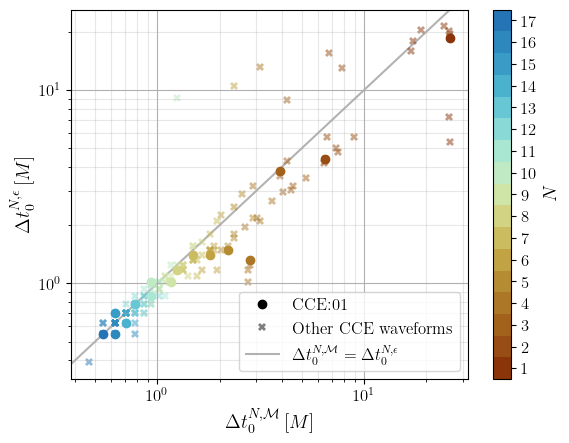

In [4]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')

# Scatter plot of Delta_t0_M vs Delta_t0_E
# ----------------------------------------

for ID in delta_t0_M.columns:
    for N in N_list: 

        if ID == '1':
            alpha = 1
            marker = 'o'
            markeredgewidth = 1
            zorder = 2
        else:
            alpha = 0.5
            marker = 'X'
            markeredgewidth = 0
            zorder = 1

        ax.plot(
            delta_t0_M[ID].loc[N],
            delta_t0_E[ID].loc[N],
            c=cm.roma(N/20),
            alpha=alpha,
            marker=marker,
            markeredgewidth=markeredgewidth,
            zorder=zorder,
        )

# Colorbar
# --------

# Shift vmin and vmax by 0.5 to center the ticks
# https://stackoverflow.com/questions/14777066/matplotlib-discrete-colorbar
norm = mpl.colors.Normalize(vmin=N_min-0.5, vmax=N_max+0.5)

fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=ax, 
    ticks=range(N_min, N_max+1),
    label='$N$'
    )

# Line indicating Delta_t0_M = Delta_t0_E
# ----------------------------------------

xlim = ax.get_xlim()
ylim = ax.get_ylim()

ax.plot(
    [1e-3, 1e3], 
    [1e-3, 1e3], 
    color='k', 
    alpha=0.3, 
    zorder=0.1,
    label='$\Delta t_0^{N,\mathcal{M}}=\Delta t_0^{N,\epsilon}$'
    )

ax.set_xlim(xlim)
ax.set_ylim(ylim)

# Legend
# ------

handles = [
    mpl.lines.Line2D([0], [0], color='k', alpha=1, marker='o', markeredgewidth=1, linestyle='None'),
    mpl.lines.Line2D([0], [0], color='k', alpha=0.5, marker='X', markeredgewidth=0, linestyle='None'),
    mpl.lines.Line2D([0], [0], color='k', alpha=0.3),
    ]

labels = [
    'CCE:01',
    'Other CCE waveforms',
    '$\Delta t_0^{N,\mathcal{M}}=\Delta t_0^{N,\epsilon}$',
]

ax.legend(handles, labels, loc='lower right')

# ---

ax.grid(visible=True)
ax.grid(visible=True, which='minor', alpha=0.3)

ax.set_xlabel('$\Delta t_0^{N,\mathcal{M}}\, [M]$')
ax.set_ylabel('$\Delta t_0^{N,\epsilon}\, [M]$');

In [5]:
# Subplot with t0_M and t0_E alongside the above?

t0_M = pd.read_csv('../data/t0_data_30_to_100.csv', index_col=0)
t0_E = pd.read_csv('../data/t0N_E.csv', index_col=0)

In [6]:
N_min_t0 = 0
N_max_t0 = 20
N_list_t0 = list(range(N_min_t0,N_max_t0+1))

N_min_Delta_t0 = 1
N_max_Delta_t0 = 17
N_list_Delta_t0 = list(range(N_min_Delta_t0,N_max_Delta_t0+1))

# Create a custom colormap
color_list = [cm.roma(N/20) for N in N_list_t0]
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    None, color_list, N=len(color_list)
    )

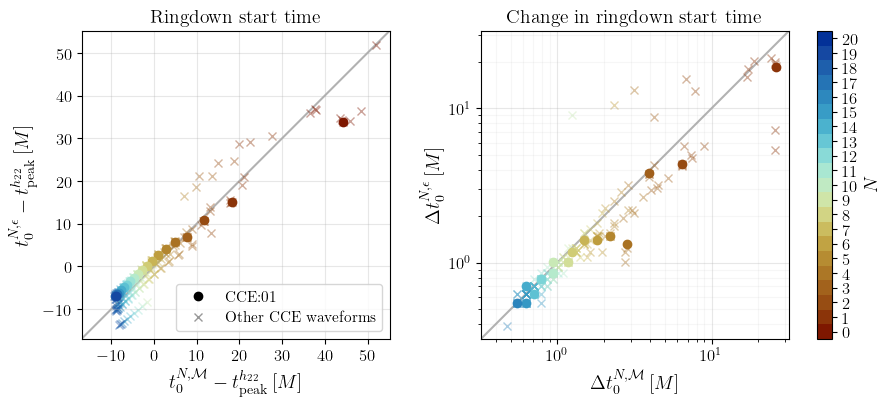

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))

axs[1].set_xscale('log')
axs[1].set_yscale('log')

for ax in axs:
    ax.set_aspect('equal')

fig.subplots_adjust(wspace=0.1)

CCE01_kwargs = dict(
    alpha=1,
    marker='o',
    zorder=2,
    )

other_kwargs = dict(
    alpha=0.4,
    marker='x',
    zorder=1,
    )

equal_line_kwargs = dict(
    color='k',
    alpha=0.3,
    zorder=0.1,
    )

# Scatter plot of t0_M vs t0_E
# ----------------------------

for ID in t0_M.columns:
    for N in N_list_t0: 

        if ID == '1':
            kwargs = CCE01_kwargs
        else:
            kwargs = other_kwargs

        axs[0].plot(
            t0_M[ID].loc[N],
            t0_E[ID].loc[N],
            c=cm.roma(N/21),
            **kwargs
        )

# Line indicating t0_M = t0_E
# ----------------------------

xlim = axs[0].get_xlim()
ylim = axs[0].get_ylim()

axs[0].plot(
    [-1e3, 1e3],
    [-1e3, 1e3],
    label='$t_0^{N,\mathcal{M}}=t_0^{N,\epsilon}$',
    **equal_line_kwargs
    )

axs[0].set_xlim(xlim)
axs[0].set_ylim(ylim)

# Scatter plot of Delta_t0_M vs Delta_t0_E
# ----------------------------------------

for ID in delta_t0_M.columns:
    for N in N_list_Delta_t0: 

        if ID == '1':
            kwargs = CCE01_kwargs
        else:
            kwargs = other_kwargs

        axs[1].plot(
            delta_t0_M[ID].loc[N],
            delta_t0_E[ID].loc[N],
            c=cm.roma(N/21),
            **kwargs
        )

# Colorbar
# --------

# Shift vmin and vmax by 0.5 to center the ticks
# https://stackoverflow.com/questions/14777066/matplotlib-discrete-colorbar
norm = mpl.colors.Normalize(vmin=N_min_t0-0.5, vmax=N_max_t0+0.5)

fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=axs, 
    ticks=range(N_min_t0, N_max_t0+1),
    label='$N$',
    pad=0.03
    )

# Line indicating Delta_t0_M = Delta_t0_E
# ----------------------------------------

xlim = axs[1].get_xlim()
ylim = axs[1].get_ylim()

axs[1].plot(
    [1e-3, 1e3], 
    [1e-3, 1e3], 
    label='$\Delta t_0^{N,\mathcal{M}}=\Delta t_0^{N,\epsilon}$',
    **equal_line_kwargs
    )

axs[1].set_xlim(xlim)
axs[1].set_ylim(ylim)

# Adjust axis limits
# ------------------

ax0_xlim = axs[0].get_xlim()
ax0_ylim = axs[0].get_ylim()

ax1_xlim = axs[1].get_xlim()
ax1_ylim = axs[1].get_ylim()

axs[0].set_xlim([min([ax0_xlim[0], ax0_ylim[0]]), max([ax0_xlim[1], ax0_ylim[1]])])
axs[0].set_ylim([min([ax0_xlim[0], ax0_ylim[0]]), max([ax0_xlim[1], ax0_ylim[1]])])

axs[1].set_xlim([min([ax1_xlim[0], ax1_ylim[0]]), max([ax1_xlim[1], ax1_ylim[1]])])
axs[1].set_ylim([min([ax1_xlim[0], ax1_ylim[0]]), max([ax1_xlim[1], ax1_ylim[1]])])

axs[0].set_xticks([-10, 0, 10, 20, 30, 40, 50])

# Legend
# ------

handles = [
    mpl.lines.Line2D([0], [0], color='k', linestyle='None', **CCE01_kwargs),
    mpl.lines.Line2D([0], [0], color='k', linestyle='None', **other_kwargs),
    ]

labels = [
    'CCE:01',
    'Other CCE waveforms',
]

axs[0].legend(handles, labels, loc='lower right', fontsize=11)

# ---

axs[0].grid(visible=True, alpha=0.3)

axs[1].grid(visible=True, which='major', alpha=0.3)
axs[1].grid(visible=True, which='minor', alpha=0.1)

axs[0].set_title('Ringdown start time')
axs[1].set_title('Change in ringdown start time')

axs[0].set_xlabel('$t_0^{N,\mathcal{M}} - t_\mathrm{peak}^{h_{22}}\, [M]$')
axs[0].set_ylabel('$t_0^{N,\epsilon} - t_\mathrm{peak}^{h_{22}}\, [M]$')

axs[1].set_xlabel('$\Delta t_0^{N,\mathcal{M}}\, [M]$')
axs[1].set_ylabel('$ \Delta t_0^{N,\epsilon}\, [M]$');

### Version with SNR

We can translate the gain in start time to a gain in SNR (the SNR gain is one of the advantages of including overtones in the ringdown). The SNR, $\rho$, is given by

\begin{align}
\rho^2 = 4 ~ \mathrm{Re} \int_0^\infty \frac{|\tilde{h}(f)|^2}{S_0(f)} ~ \mathrm{d}f. \nonumber
\end{align}

The ringdown occurs in a narrow range of frequencies, so we make the approximation $S_0(f) = S_0 = \mathrm{const}$ to get

\begin{align}
\rho^2 &\approx \frac{4}{S_0} ~ \mathrm{Re} \int_0^\infty |\tilde{h}(f)|^2 ~ \mathrm{d}f \nonumber \\ 
&\approx \frac{2}{S_0} ~ \mathrm{Re} \int_{-\infty}^\infty |\tilde{h}(f)|^2 ~ \mathrm{d}f \nonumber \\
&\approx \frac{2}{S_0} ~ \mathrm{Re} \int_0^\infty |h(t)|^2 ~ \mathrm{d}t \nonumber
\end{align}

where in the last line we used Parseval's theorem. If $\rho_N$ is the SNR of a ringdown model with $N$ overtones, then we can compute the ratio

\begin{align}
\frac{\rho_N}{\rho_0} = \mathrm{Re} \sqrt{ \frac{\int_0^\infty |h(t; t_0 = t_0^N)|^2 ~ \mathrm{d}t}{\int_0^\infty |h(t; t_0 = t_0^{N=0})|^2 ~ \mathrm{d}t} }. \nonumber
\end{align}

The PSD cancels out, as well as anything that multiplies $h$ (for example, the overall mass scale, or the distance to the source).

In [8]:
# Use the average of t0_M and t0_E
average_t0s = []
for t0_MN, t0_EN in zip(t0_M['1'].values, t0_E['1'].values):
    average_t0s.append((t0_MN + t0_EN)/2)
average_t0s = np.array(average_t0s)[:17+1]

In [9]:
sim_info = utils.load_cce_data(1)
sim = sim_info['sim']

In [10]:
wf_dict = {}
for N, t0 in enumerate(average_t0s):
    times = sim.times[sim.times >= t0]
    data = sim.h[2,2][sim.times >= t0]
    wf_dict[N] = {
        'times': times,
        'data': data,
    }

In [11]:
snr_list = []
for N in range(0, 17+1):
    wf = wf_dict[N]
    model = np.real(wf['data'])
    times = wf['times']

    # Calculate the SNR
    snr = np.sqrt(
        simpson(np.abs(model)**2, times)
    )
    snr_list.append(snr)

snr_list = np.array(snr_list)
print(f'Dividing by rho = {snr_list[0]} to normalize the SNR values.')
snr_list /= snr_list[0]
snr_list

Dividing by rho = 0.06188962953808612 to normalize the SNR values.


array([ 1.        ,  6.13218111,  8.71991474, 12.49126545, 12.69412032,
       14.16581301, 16.13765131, 17.40037336, 17.75257089, 17.78770069,
       17.85543914, 18.10531224, 18.53413642, 19.13145953, 19.75949573,
       20.33988538, 20.89920551, 21.3450827 ])

It might be nicer to plot something like $\rho_0$, $5\rho_0$, $10\rho_0$, $15\rho_0$, $20\rho_0$. So, we need to find the start times that give these SNR ratios.

In [12]:
def snr_diff(t0, target_snr_ratio):
    """
    Calculate the difference between the SNR ratio and a target SNR ratio for
    a given t0 value (minimizing this function will find the t0 that gives the
    desired SNR ratio).
    """
    times = sim.times[sim.times >= t0]
    data = np.real(sim.h[2,2][sim.times >= t0])
    # Divide by the SNR rho_0
    snr_ratio = np.sqrt(simpson(np.abs(data)**2, times))/0.06188962953808612
    # print(snr_ratio)
    return (snr_ratio - target_snr_ratio)**2


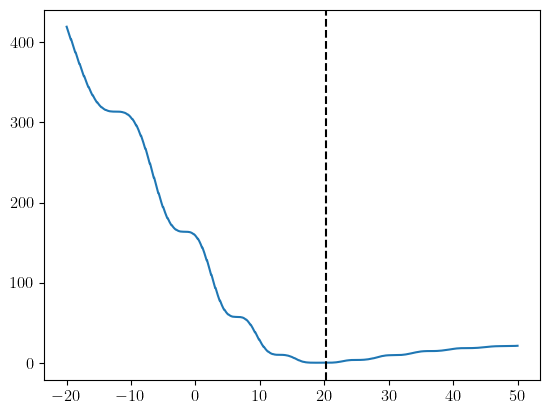

In [13]:
t0_array = np.linspace(-20, 50, 1000)
snr_ratio_target = 5
snr_diff_array = []
for t0 in t0_array:
    snr_diff_array.append(snr_diff(t0, snr_ratio_target))
snr_diff_array = np.array(snr_diff_array)

fig, ax = plt.subplots()
ax.plot(t0_array, snr_diff_array)
ax.axvline(t0_array[np.argmin(snr_diff_array)], color='k', linestyle='--')

In [14]:
t0_array = np.linspace(-10, 50, 1000)
snr_ratio_targets = [1, 5, 10, 15, 20]
t0_targets = []

for snr_ratio_target in snr_ratio_targets:

    snr_diff_array = []
    for t0 in t0_array:
        snr_diff_array.append(snr_diff(t0, snr_ratio_target))
    snr_diff_array = np.array(snr_diff_array)

    t0_targets.append(t0_array[np.argmin(snr_diff_array)])

In [15]:
t0_targets

[np.float64(39.009009009009006),
 np.float64(20.27027027027027),
 np.float64(10.18018018018018),
 np.float64(2.8528528528528536),
 np.float64(-6.216216216216216)]

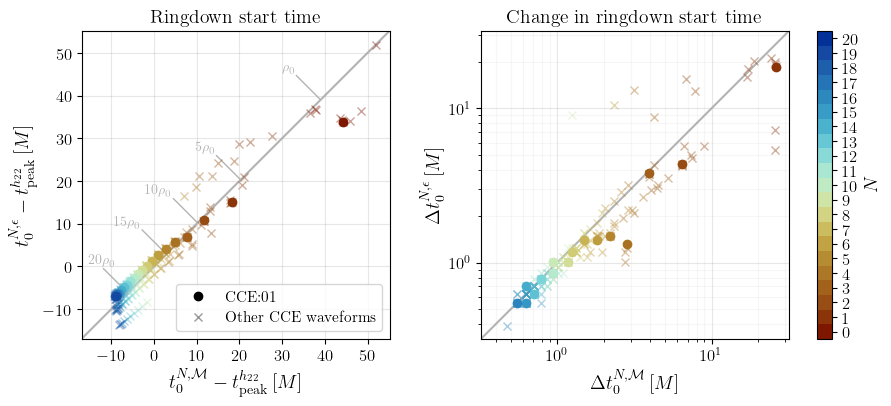

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))

axs[1].set_xscale('log')
axs[1].set_yscale('log')

for ax in axs:
    ax.set_aspect('equal')

fig.subplots_adjust(wspace=0.1)

CCE01_kwargs = dict(
    alpha=1,
    marker='o',
    zorder=2,
)

other_kwargs = dict(
    alpha=0.4,
    marker='x',
    zorder=1,
)

equal_line_kwargs = dict(
    color='#b3b3b3',
    zorder=0.1,
)

# Scatter plot of t0_M vs t0_E
# ----------------------------

for ID in t0_M.columns:
    for N in N_list_t0: 

        if ID == '1':
            kwargs = CCE01_kwargs
        else:
            kwargs = other_kwargs

        axs[0].plot(
            t0_M[ID].loc[N],
            t0_E[ID].loc[N],
            c=cm.roma(N/21),
            **kwargs
        )

# Line indicating t0_M = t0_E
# ----------------------------

xlim = axs[0].get_xlim()
ylim = axs[0].get_ylim()

axs[0].plot(
    [-1e3, 1e3],
    [-1e3, 1e3],
    label='$t_0^{N,\mathcal{M}}=t_0^{N,\epsilon}$',
    **equal_line_kwargs
    )

axs[0].set_xlim(xlim)
axs[0].set_ylim(ylim)

# Scatter plot of Delta_t0_M vs Delta_t0_E
# ----------------------------------------

for ID in delta_t0_M.columns:
    for N in N_list_Delta_t0: 

        if ID == '1':
            kwargs = CCE01_kwargs
        else:
            kwargs = other_kwargs

        axs[1].plot(
            delta_t0_M[ID].loc[N],
            delta_t0_E[ID].loc[N],
            c=cm.roma(N/21),
            **kwargs
        )

# Colorbar
# --------

# Shift vmin and vmax by 0.5 to center the ticks
# https://stackoverflow.com/questions/14777066/matplotlib-discrete-colorbar
norm = mpl.colors.Normalize(vmin=N_min_t0-0.5, vmax=N_max_t0+0.5)

fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=axs, 
    ticks=range(N_min_t0, N_max_t0+1),
    label='$N$',
    pad=0.03
    )

# Line indicating Delta_t0_M = Delta_t0_E
# ----------------------------------------

xlim = axs[1].get_xlim()
ylim = axs[1].get_ylim()

axs[1].plot(
    [1e-3, 1e3], 
    [1e-3, 1e3], 
    label='$\Delta t_0^{N,\mathcal{M}}=\Delta t_0^{N,\epsilon}$',
    **equal_line_kwargs
    )

axs[1].set_xlim(xlim)
axs[1].set_ylim(ylim)

# Markers indicating times of equal SNR gain

l = 8
labels = [r'$\rho_0$', r'$5\rho_0$', r'$10\rho_0$', r'$15\rho_0$', r'$20\rho_0$']
for i, (t0, label) in enumerate(zip(t0_targets, labels)):
    axs[0].plot(
        [t0, t0-l*np.cos(np.pi/4)],
        [t0, t0+l*np.sin(np.pi/4)],
        lw=1,
        **equal_line_kwargs,
    )
    if i == 4:
        adjust_x = 2.5
        adjust_y = 0.5
    else:
        adjust_x = -0.5
        adjust_y = 0.5
    axs[0].text(
        t0-l*np.cos(np.pi/4)+adjust_x, 
        t0+l*np.sin(np.pi/4)+adjust_y,
        label,
        fontsize=10,
        color=equal_line_kwargs['color'],
        ha='right',
        va='bottom'
    )

# Adjust axis limits
# ------------------

ax0_xlim = axs[0].get_xlim()
ax0_ylim = axs[0].get_ylim()

ax1_xlim = axs[1].get_xlim()
ax1_ylim = axs[1].get_ylim()

axs[0].set_xlim([min([ax0_xlim[0], ax0_ylim[0]]), max([ax0_xlim[1], ax0_ylim[1]])])
axs[0].set_ylim([min([ax0_xlim[0], ax0_ylim[0]]), max([ax0_xlim[1], ax0_ylim[1]])])

axs[1].set_xlim([min([ax1_xlim[0], ax1_ylim[0]]), max([ax1_xlim[1], ax1_ylim[1]])])
axs[1].set_ylim([min([ax1_xlim[0], ax1_ylim[0]]), max([ax1_xlim[1], ax1_ylim[1]])])

axs[0].set_xticks([-10, 0, 10, 20, 30, 40, 50])

# Legend
# ------

handles = [
    mpl.lines.Line2D([0], [0], color='k', linestyle='None', **CCE01_kwargs),
    mpl.lines.Line2D([0], [0], color='k', linestyle='None', **other_kwargs),
    ]

labels = [
    'CCE:01',
    'Other CCE waveforms',
]

axs[0].legend(handles, labels, loc='lower right', fontsize=11)

# ---

axs[0].grid(visible=True, alpha=0.3)

axs[1].grid(visible=True, which='major', alpha=0.3)
axs[1].grid(visible=True, which='minor', alpha=0.1)

axs[0].set_title('Ringdown start time')
axs[1].set_title('Change in ringdown start time')

axs[0].set_xlabel('$t_0^{N,\mathcal{M}} - t_\mathrm{peak}^{h_{22}}\, [M]$')
axs[0].set_ylabel('$t_0^{N,\epsilon} - t_\mathrm{peak}^{h_{22}}\, [M]$')

axs[1].set_xlabel('$\Delta t_0^{N,\mathcal{M}}\, [M]$')
axs[1].set_ylabel('$ \Delta t_0^{N,\epsilon}\, [M]$')

fig.savefig('figures/ringdown_start_time.pdf', bbox_inches='tight')